# © ArviZ devs 2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

# Motivating case: Multimodal distribution

In [2]:
np.random.seed(55)
dat1 = stats.norm.rvs(loc=0, scale=3, size=1000)
dat2 = stats.norm.rvs(loc=5, scale=0.3, size=1000)
data = np.r_[dat1, dat2]

## Histogram

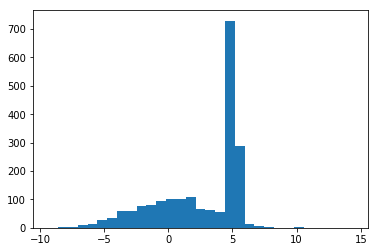

In [3]:
plt.hist(data, bins="fd");

## Quantile binned regression

In [4]:
bins = np.quantile(data, np.linspace(0,1,len(data)//30))

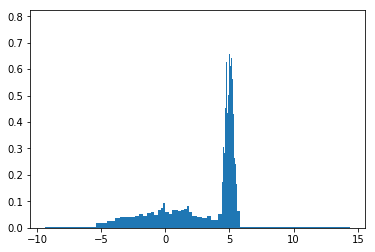

In [5]:
plt.hist(data, bins, density=True);

In [6]:
from scipy.integrate import simps

In [7]:
def fast_quantile_kde(x, bw_scaler=None):
    len_x = len(x)
    n_points = 200
    if bw_scaler is None:
        bw_scaler = 1
    bw = 3.5 * bw_scaler
    xmin = np.min(x)
    xmax = np.max(x)

    assert np.min(x) >= xmin
    assert np.max(x) <= xmax

    log_len_x = np.log(len_x) * bw

    # HOW MANY BINS?? 
    n_bins = min(int(len_x ** (1 / 3) * log_len_x), n_points)
    
    # Create bins and "fill" too large (=areas without data) areas with "normal" bins
    bins = np.quantile(x, np.linspace(0,1,n_bins))
    new_bin_locs = []
    default_width = (xmax - xmin) / n_bins
    for i, val in enumerate(np.diff(bins)):
        if val > default_width:
            number_of_new_bins = int(np.ceil(val / default_width))
            new_bin_locs.extend(np.linspace(bins[i], bins[i+1], number_of_new_bins+2)[1:-1])
    bins = np.sort(list(bins) + new_bin_locs)
    n_bins = len(bins) - 1
    grid, _ = np.histogram(x, bins, range=(xmin, xmax))
    
    # Normalize counts to "density"
    bins_diff = np.diff(bins)
    bins_diff /= bins_diff.sum()
    grid = grid / bins_diff
    
    # mean bin width
    d_x = (xmax - xmin) / (n_bins - 1)
    scotts_factor = len_x ** (-0.2)
    kern_nx = int(scotts_factor * 2 * np.pi * log_len_x)
    kernel = signal.gaussian(kern_nx * 2, scotts_factor * log_len_x)
    
    npad = min(n_bins, 2 * kern_nx)
    grid = np.concatenate([grid[npad:0:-1], grid, grid[n_bins : n_bins - npad : -1]])
    density = signal.convolve(grid, kernel, mode="same", method="direct")[npad : npad + n_bins]
    
    # There must be better way to do this
    mean_bins = (bins[1:]+bins[:-1])/2
    # Integrate to 1
    norm_factor = simps(density, mean_bins)
    density /= norm_factor
    
    
    return mean_bins, density

In [8]:
def fast_kde(x):
    
    # Corrent implementation
    len_x = len(x)
    n_points = 200
    bw = 3.5
    xmin = np.min(x)
    xmax = np.max(x)

    assert np.min(x) >= xmin
    assert np.max(x) <= xmax

    log_len_x = np.log(len_x) * bw

    n_bins = min(int(len_x ** (1 / 3) * log_len_x * 2), n_points)

    d_x = (xmax - xmin) / (n_bins - 1)
    grid, _ = np.histogram(x, n_bins, range=(xmin, xmax))

    scotts_factor = len_x ** (-0.2)
    kern_nx = int(scotts_factor * 2 * np.pi * log_len_x)
    kernel = signal.gaussian(kern_nx * 2, scotts_factor * log_len_x)

    npad = min(n_bins, 2 * kern_nx)
    grid = np.concatenate([grid[npad:0:-1], grid, grid[n_bins : n_bins - npad : -1]])
    density = signal.convolve(grid, kernel, mode="same", method="auto")[npad : npad + n_bins]
    norm_factor = len_x * d_x * (2 * np.pi * log_len_x ** 2 * scotts_factor ** 2) ** 0.5

    density /= norm_factor
    return np.linspace(xmin, xmax, len(density)), density

# Multi-modal

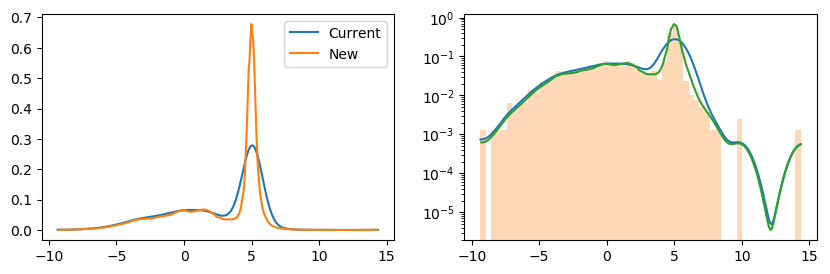

In [9]:
np.random.seed(55)
dat1 = stats.norm.rvs(loc=0, scale=3, size=1000)
dat2 = stats.norm.rvs(loc=5, scale=0.3, size=1000)
data = np.r_[dat1, dat2]

bins, density = fast_kde(data)
bins_, density_ = fast_quantile_kde(data)

plt.figure(figsize=(10,3), dpi=100)
plt.subplot(121)
plt.plot(bins, density, label="Current")
plt.plot(bins_, density_, label="New")
plt.legend()

plt.subplot(122)
plt.plot(bins, density)
plt.hist(data, density=True, bins=60, alpha=0.3);
plt.plot(bins_, density_)
plt.yscale("log")

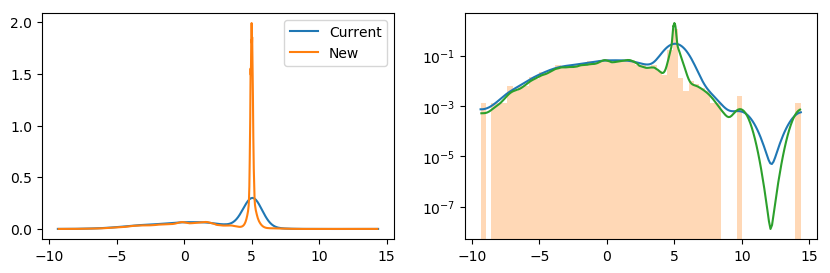

In [10]:
np.random.seed(55)
dat1 = stats.norm.rvs(loc=0, scale=3, size=1000)
dat2 = stats.norm.rvs(loc=5, scale=0.1, size=1000)
data = np.r_[dat1, dat2]

bins, density = fast_kde(data)
bins_, density_ = fast_quantile_kde(data, bw_scaler=0.7)

plt.figure(figsize=(10,3), dpi=100)
plt.subplot(121)
plt.plot(bins, density, label="Current")
plt.plot(bins_, density_, label="New")
plt.legend()

plt.subplot(122)
plt.plot(bins, density)
plt.hist(data, density=True, bins=60, alpha=0.3);
plt.plot(bins_, density_)
plt.yscale("log")

# Univariate

### The bw should be larger for the new method (more bins etc?)

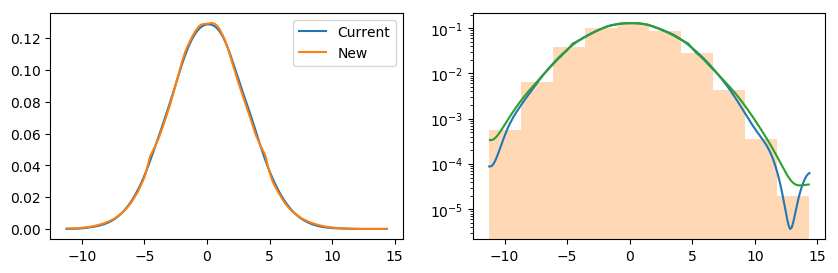

In [11]:
np.random.seed(55)
dat1 = stats.norm.rvs(loc=0, scale=3, size=20000)
#dat2 = stats.norm.rvs(loc=5, scale=0.1, size=1000)
data = np.r_[dat1]

bins, density = fast_kde(data)
bins_, density_ = fast_quantile_kde(data, bw_scaler=2)

plt.figure(figsize=(10,3), dpi=100)
plt.subplot(121)
plt.plot(bins, density, label="Current")
plt.plot(bins_, density_, label="New")
plt.legend()

plt.subplot(122)
plt.plot(bins, density)
plt.hist(data, density=True, bins=10, alpha=0.3);
plt.plot(bins_, density_)
plt.yscale("log")

# LOW DATA CASE:

### High bw is failing somehow

C:\Users\aohartik\miniconda3\envs\stan\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


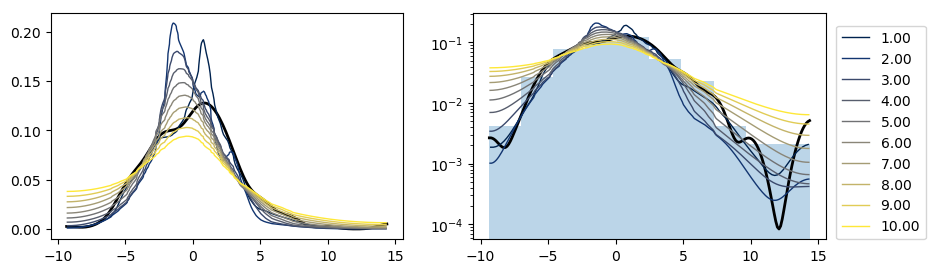

In [12]:
np.random.seed(55)
dat1 = stats.norm.rvs(loc=0, scale=3, size=200)
#dat2 = stats.norm.rvs(loc=5, scale=0.1, size=1000)
data = np.r_[dat1]

plt.figure(figsize=(10,3), dpi=100)

bins, density = fast_kde(data)
plt.subplot(121)
plt.plot(bins, density, color="k", lw=2)
plt.subplot(122)
plt.plot(bins, density, color="k", lw=2)

for bw_scaler, color in zip(np.linspace(1, 10, 10), plt.cm.cividis(np.linspace(0,1,10))):
    bins_, density_ = fast_quantile_kde(data, bw_scaler=bw_scaler)
    
    plt.subplot(121)
    plt.plot(bins_, density_, color=color, lw=1)
    
    plt.subplot(122)
    plt.plot(bins_, density_, color=color, label=f"{bw_scaler:.2f}", lw=1)

plt.hist(data, density=True, bins=10, alpha=0.3);
plt.yscale("log")
plt.legend(loc=(1.03,0))

### lower bw is better

C:\Users\aohartik\miniconda3\envs\stan\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


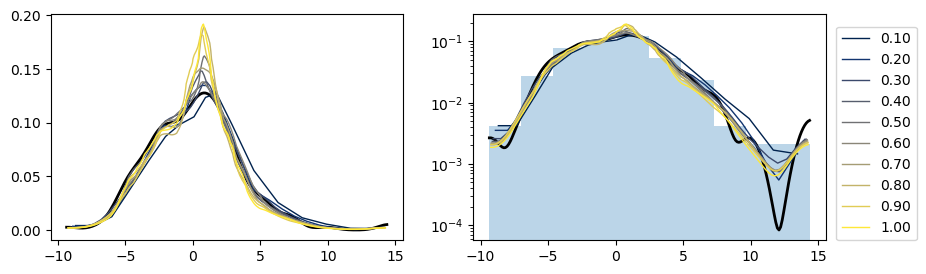

In [13]:
np.random.seed(55)
dat1 = stats.norm.rvs(loc=0, scale=3, size=200)
#dat2 = stats.norm.rvs(loc=5, scale=0.1, size=1000)
data = np.r_[dat1]

plt.figure(figsize=(10,3), dpi=100)

bins, density = fast_kde(data)
plt.subplot(121)
plt.plot(bins, density, color="k", lw=2)
plt.subplot(122)
plt.plot(bins, density, color="k", lw=2)

for bw_scaler, color in zip(np.linspace(0.1, 1, 10), plt.cm.cividis(np.linspace(0,1,10))):
    bins_, density_ = fast_quantile_kde(data, bw_scaler=bw_scaler)
    
    plt.subplot(121)
    plt.plot(bins_, density_, color=color, lw=1)
    
    plt.subplot(122)
    plt.plot(bins_, density_, color=color, label=f"{bw_scaler:.2f}", lw=1)

plt.hist(data, density=True, bins=10, alpha=0.3);
plt.yscale("log")
plt.legend(loc=(1.03,0))

# There must be some optimum bw that changes against sample size or the with the correction

# Also currently all the corrections are probably invalid and need careful ideas